# Calculo periodos de retornos multivariados

In [1]:
import numpy as np
import pandas as pd

import os
ruta = os.getcwd() + '\\'

import scipy
from scipy import stats
from scipy.stats import norm, multivariate_normal, genextreme, gamma, expon
from scipy.optimize import root

from fitter import Fitter

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn-whitegrid')
%matplotlib inline
# %matplotlib notebook
# %pylab
# from mpl_toolkits.mplot3d import Axes3D

# import sys
# import tqdm
from math import pi
import calendar
# import pickle

In [2]:
# funciones para calcular la cdf una cópula gaussiana, y la
# pdf, cdf y ppf de las marginales
os.chdir(ruta)
%run COP-funciones_normal_multivariada.ipynb

T Copula Python calculation matches Matlab!


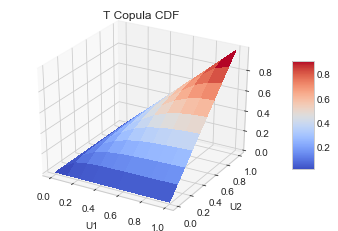

Gaussian Copula Python calculation matches Matlab!


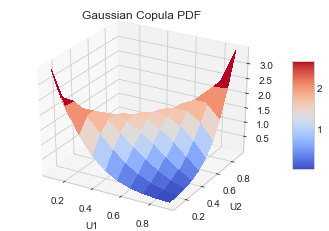

T Copula Python calculation matches Matlab!


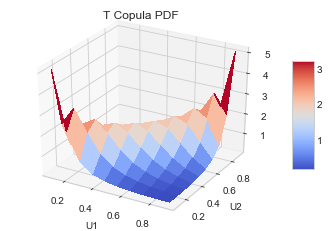

Clayton Copula Python calculation matches Matlab!


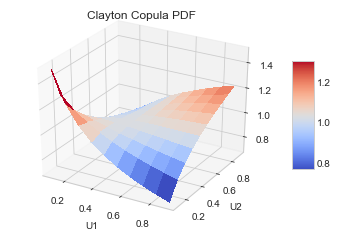

Gumbel Copula Python calculation matches Matlab!


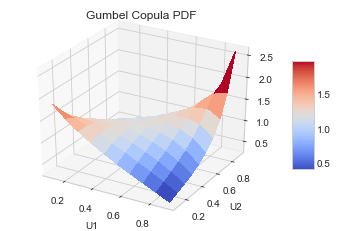

Frank Copula Python calculation matches Matlab!


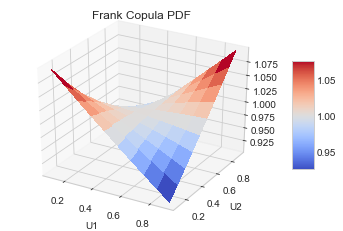

In [3]:
#os.chdir('F:/OneDrive - Universidad de Cantabria/Clases/TFM19/Codigo/copula-py-master')
os.chdir('C:/Users/jcr693/OneDrive - Universidad de Cantabria/Clases/TFM19/Codigo/copula-py-master')
%run copulafit
%run copulacdf.py
%run copulapdf.py

In [4]:
def ecdf(data, plot=False):
    """Compute (and plot) the empirical cumulative distribution function (ECDF)"""
    
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 1) / n
    
    if plot == True:
        plt.scatter(x=x, y=y);
        plt.xlabel('x', fontsize=12)
        plt.ylabel('y', fontsize=12)
        plt.ylim(0, 1.);
    
    return x, y

## Configuración y datos
#### Configuración

In [5]:
# variable utilizada en la selección de eventos extremos
varObj = 'N_m'

# variables con las que construir la cópula
varCop = ['P2d_mm', 'P3d_mm']

# periodos de retorno
Ts = np.array([10, 100])

In [6]:
labels = {'P_mm': 'P (mm)',
          'P2d_mm': 'P2d (mm)',
          'P3d_mm': 'P3d (mm)',
          'N_m': 'N (mm)',
          'Q_cms': 'Q (m³/s)'}
extents = {'N_m': 8,
           'Q_cms': 800,
           'P_mm': 160,
           'P2d_mm': 250,
           'P3d_mm': 300}
axmax =  {'N_m': 1,
           'Q_cms': .005,
           'P_mm': .05,
           'P2d_mm': .03,
           'P3d_mm': .03}

In [7]:
extent = [0, extents[varCop[0]], 0, extents[varCop[1]]]#[0, 140, 0, 100]#

### Series de eventos bivariados y marginales asociadas
Se carga la serie de eventos extremos definidos en base a la variable objetivo y las funciones de distribución ajustadas a dichas series.

In [9]:
# serie de extremos de las dos variales
anualMax = pd.read_csv(ruta + 'Serie de extremos ' + varObj + ' (Angelica).csv',
                       index_col=0)

In [10]:
# tipo de distribución marginal y parámetros ajustados
marginales = pd.read_csv(ruta + 'Marginales ' + varObj + ' (Angelica).csv',
                         index_col=0)
marginales.loc[marginales.tipo == 'gumbel_r', 'tipo'] = 'genextreme'

##### Corregir ajuste de la marginal de P_mm
Porque hay valores de precipitación nulos (o casi nulos) que hacen que el ajuste de una distribución de extremos esa errónea.

In [ ]:
# extraer serie y eliminar datos nulos o próximos
P_mm = anualMax.P_mm
mask = P_mm < 1
P_mm = P_mm.loc[~mask]

In [ ]:
# buscar distribución con mejor rendimiento
distributions = ['beta', 'expon', 'frechet_r', 'gamma', 'genextreme',
                 'gumbel_r', 'norm', 'weibull_max']
F = Fitter(P_mm, distributions=distributions)
F.fit()
F.summary()

In [ ]:
# distribución empírica
xecdf, yecdf = ecdf(P_mm, plot=False)

# ajustar distribuciones
parGEV = genextreme.fit(P_mm)
parGumbel = genextreme.fit(P_mm, f0=0)
parGamma = gamma.fit(P_mm)
parExpon = expon.fit(P_mm)

In [ ]:
# calcular cdf y pdf de las distribuciones
x = np.linspace(0, 100, 101)

cdfGEV = genextreme.cdf(x, *parGEV)
pdfGEV = genextreme.pdf(x, *parGEV)
cdfGumbel = genextreme.cdf(x, *parGumbel)
pdfGumbel = genextreme.pdf(x, *parGumbel)
cdfGamma = gamma.cdf(x, *parGamma)
pdfGamma = gamma.pdf(x, *parGamma)
cdfExpon = expon.cdf(x, *parExpon)
pdfExpon = expon.pdf(x, *parExpon)

In [ ]:
# gráfico de comparación
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].scatter(xecdf, yecdf)
ax[0].plot(x, cdfGEV, label='GEV')
ax[0].plot(x, cdfGumbel, label='Gumbel')
ax[0].plot(x, cdfGamma, label='Gamma')
ax[0].plot(x, cdfExpon, label='Expon')

ax[1].plot(x, pdfGEV)
ax[1].plot(x, pdfGumbel)
ax[1].plot(x, pdfGamma)
ax[1].plot(x, pdfExpon);

fig.legend();

In [ ]:
# modificar os parámetros de la distribución
marginales.loc['P_mm', ['c', 'loc', 'scale']] = parGEV

In [ ]:
# distribución marginal y parámetros de las dos variables de la cópul
distMarg = list(marginales.loc[varCop, 'tipo'])
GEVpars = ['c', 'loc', 'scale']
parsMarg = (marginales.loc[varCop, GEVpars].values)

In [ ]:
# normalizar la serie de extremos
anualMaxNorm = pd.DataFrame(index=anualMax.index, columns=anualMax.columns)
for i, var in enumerate(anualMaxNorm.columns):
    cdf = cdfMarginals(marginales.loc[var, 'tipo'],
                       marginales.loc[var, GEVpars], anualMax[var])
    anualMaxNorm[var] = ppfMarginals('norm', [0, 1], cdf)

In [ ]:
# medias y matriz de correlaciones
means = anualMaxNorm[varCop].mean().values
cov = anualMaxNorm[varCop].corr(method='spearman').values

print('medias:\n', means, sep='')
print('matriz correlación:\n', cov, sep='')

### Series de extremos univariados y distribuciones univariadas asociadas
Se carga la serie anual de eventos extremos de cada una de las variables de la cópula y las funciones de distribución ajustadas a dichas series.

In [ ]:
# distribuciones univariadas
univariadas = pd.read_csv(ruta + 'Distribuciones univariadas (Angelica).csv',
                          index_col=0)
univariadas.loc[univariadas.tipo == 'gumbel_r', 'tipo'] = 'genextreme'

distUniv = list(univariadas.loc[varCop, 'tipo'])
parsUniv = (univariadas.loc[varCop, GEVpars].values)

In [ ]:
# serie de extremos reales de las dos variales
anualMaxReal = pd.read_csv(ruta + 'Serie de extremos reales (Angelica).csv',
                           index_col=0)
if any(anualMaxReal.columns != marginales.index):
    print('¡ERROR! Distintas variables en las marginales y las series de extremos')

## Cópula gaussiana y escenarios

In [ ]:
n = 1000 # nº de valores en cada variable

### Ajustar la cópula

In [ ]:
# dataframe con las series UNIFORMIZADAS de las variables de la cópula
df = pd.DataFrame()
for dist, pars, var in zip(distMarg, parsMarg, varCop):
    df[var] = cdfMarginals(dist, pars, anualMax[var])
    
# matriz de correlación (Kendalls's Tau)
Rho = copulafit('Gaussian', df.values, algorithm='PKTE')

### Escenarios O e Y

In [ ]:
# VALORES ALEATORIOS
# ==================
# generar valores aleatorios en la cópula
rvNorm = np.random.multivariate_normal(means, Rho, 5000)
# Reconvertir los valores aleatorios a las marginales
rvMarg = np.empty((rvNorm.shape[0], rvNorm.shape[1]))
for i in range(2):
    rvMarg[:, i] = ppfMarginals(distMarg[i], parsMarg[i], rvNorm[:, i])

In [ ]:
# ESCENARIOS
# ==========
# valores linealmente distribuidos de las dos variables 
v0 = np.linspace(extent[0], extent[1], n)
v1 = np.linspace(extent[2], extent[3], n)

# Escenario Y
# -----------
# probabilidad de excedencia de las marginales en 1D
Pe0 = 1 - cdfMarginals(distMarg[0], parsMarg[0], v0)
Pe1 = 1 - cdfMarginals(distMarg[1], parsMarg[1], v1)
# probabilidad de excedencia de las marginales en 2D
[PPe0, PPe1] = np.meshgrid(Pe0, Pe1)
u = np.vstack((PPe0.flatten(), PPe1.flatten())).T
# calcular PDF (probabilidad de cada celda) de la cópula
pdfAND_2D = copulapdf('Gaussian', u, Rho).reshape((n, n))
# calcular cdf (probabilidad de no excedencia) de la cópula
cdfAND_2D = copulacdf('Gaussian', u, Rho).reshape((n, n))

# Escenario O
# -----------
# probabilidad de NO EXCEDENCIA de las marginales en 1D
Pne0 = cdfMarginals(distMarg[0], parsMarg[0], v0)
Pne1 = cdfMarginals(distMarg[1], parsMarg[1], v1)
# probabilidad de NO EXCEDENCIA de las marginales en 2D
[PPne0, PPne1] = np.meshgrid(Pne0, Pne1)
u = np.vstack((PPne0.flatten(), PPne1.flatten())).T
# calcular PDF (probabilidad de cada celda) de la cópula
pdfOR_2D = copulapdf('Gaussian', u, Rho).reshape((n, n))
# calcular cdf (probabilidad de no excedencia) de la cópula
cdfOR_2D = copulacdf('Gaussian', u, Rho).reshape((n, n))

In [ ]:
# EVENTO DE 2019
# ==============
x19, y19 = anualMax.loc[2019, varCop[0]], anualMax.loc[2019, varCop[1]]

# Univariado
# ----------
TxUniv19 = int(1 / (1 - cdfMarginals(distUniv[0], parsUniv[0], x19)))
TyUniv19 = int(1 / (1 - cdfMarginals(distUniv[1], parsUniv[1], y19)))

# Escenario O
# -----------
# probabilidad de NO EXCEDENCIA de las marginales en 1D
Pne0 = cdfMarginals(distMarg[0], parsMarg[0], x19)
Pne1 = cdfMarginals(distMarg[1], parsMarg[1], y19)
u = np.array([[Pne0, Pne1]])
# calcular periodo de retorno del evento de 2019 en la cópula
TrOR = int(1 / (1 - copulacdf('Gaussian', u, Rho)[0]))

# Escenario AND
# -------------
# probabilidad de NO EXCEDENCIA de las marginales en 1D
Pe0 = 1 - cdfMarginals(distMarg[0], parsMarg[0], anualMax.loc[2019, varCop[0]])
Pe1 = 1 - cdfMarginals(distMarg[1], parsMarg[1], anualMax.loc[2019, varCop[1]])
u = np.array([[Pe0, Pe1]])
# calcular periodo de retorno del evento de 2019 en la cópula
TrAND = int(1 / copulacdf('Gaussian', u, Rho)[0])

### Gráfico 2D

In [ ]:
# GRÁFICO
# =======
# configuración
fig = plt.figure(figsize=(6, 6))
# divide el gráfico en una malla de 4x4 celdas
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main = fig.add_subplot(grid[:-1, 1:]) # las 9 celdas de arriba a la derecha son el gráfico principal
yMarg = fig.add_subplot(grid[:-1, 0]) # la 1ª columna para la marginal Y
xMarg = fig.add_subplot(grid[-1, 1:]) # la 4ª fila para la marginal X
main.set_xlim(extent[:2])
main.set_ylim(extent[2:])


# GRÁFICO PRINCIPAL
# -----------------

# puntos aleatorios
main.scatter(rvMarg[:, 0], rvMarg[:, 1],
             marker='.', c='grey', s=1, alpha=.5, label='aleatorios', zorder=2)

# eventos observados
main.scatter(anualMax[varCop[0]], anualMax[varCop[1]],
             marker='.', c='k', s=12, label='observados', zorder=3)

# evento 2019
main.scatter(x19, y19,marker='.', c='k', s=80, label='ene 19', zorder=4)
main.text(x19 + extent[1] / 50, y19 + extent[3] / 50, 'T = ' + str(TrAND),
          fontsize=11, color='maroon', verticalalignment='center', horizontalalignment='left')
main.text(x19 + extent[1] / 50, y19 - extent[3] / 50, 'T = ' + str(TrOR),
          fontsize=11, color='midnightblue', verticalalignment='center', horizontalalignment='left')
main.vlines(x19, 0, y19, 'k', linestyle=':', lw=.4)
main.annotate('T = ' + str(TxUniv19), xy=(x19, 0), xytext=(x19, extent[3]/10),
              color='olive', fontsize=11, horizontalalignment='center', verticalalignment='bottom', rotation=90,
              arrowprops=dict(arrowstyle="->", color='olive', lw=1))
main.hlines(y19, 0, x19, 'k', linestyle=':', lw=.4)
main.annotate('T = ' + str(TyUniv19), xy=(0, y19), xytext=(extent[1]/10, y19),
              color='olive', fontsize=11, horizontalalignment='left', verticalalignment='center',
              arrowprops=dict(arrowstyle="->", color='olive', lw=1))

# calcular contornos de periodo de retorno
contAND = main.contour(1 / cdfAND_2D, Ts, colors='indianred', extent=extent, alpha=0)
contOR = main.contour(1 / (1 - cdfOR_2D), Ts, colors='indianred', extent=extent, alpha=0)

# puntos de máxima probabilidad (PMP)
aux = pd.DataFrame(index=Ts, columns=['var1', 'var2'])
PMP = {scn: aux.copy() for scn in ['AND', 'OR']}
del aux
for (scn, contour, cmap, c) in zip(['AND', 'OR'], [contAND, contOR],
                                   ['Reds', 'Blues'], ['maroon', 'midnightblue']):
    for i, T in enumerate(Ts):
        # extraer puntos de los contornos
        points = contour.collections[i].get_paths()[0].vertices
        # uniformizar los puntos
        xUnif = cdfMarginals(distMarg[0], parsMarg[0], points[:,0])
        yUnif = cdfMarginals(distMarg[1], parsMarg[1], points[:,1])
        xyUnif = np.vstack((xUnif, yUnif)).T
        # calcular probabilidad de no excendencia (pdf) de los puntos uniformizados
        if scn == 'AND':
            pdf = np.round(copulapdf('Gaussian', xyUnif, Rho), 3)
        elif scn == 'OR':
            pdf = np.round(copulapdf('Gaussian', xyUnif, Rho), 3) # ¿por qué?
        # punto de máxima probabilidad
        MP = points[pdf.argmax(),:]
        PMP[scn].loc[T,:] = MP
        # plotear contornos de periodo de retorno
        main.scatter(points[:,0], points[:,1], c=pdf, cmap=cmap, s=.25)
        # plotear máxima probabilidad
        main.scatter(MP[0], MP[1], marker='x', c=c, s=70, lw=1.2)
    # leyenda
    main.plot([-10, -10], [0,-10], c=c, label=scn)
    main.scatter(-10, -10, marker='x', c=c, s=70, lw=1.2, label='MaxProb '+ scn)

# configuración
main.set(xlim=(extent[0], extent[1]), ylim=(extent[2], extent[3]))
main.set_xticklabels([])
main.set_yticklabels([])
        
# MARGINAL X
# ----------
# xMarg.rcParams['xtick.bottom'] = xMarg.rcParams['xtick.labelbottom'] = False
# xMarg.rcParams['xtick.top'] = xMarg.rcParams['xtick.labeltop'] = True
ymax = axmax[varCop[0]] # máximo del eje y

# Distribución marginal
# .....................
# función de densidad
xMarg.fill_between(v0, pdfMarginals(distMarg[0], parsMarg[0], v0), color='grey', alpha=.25)
# valor del periodo de retorno
ppfs = ppfMarginals(distMarg[0], parsMarg[0], 1 - 1 / Ts)
pdfs = pdfMarginals(distMarg[0], parsMarg[0], ppfs)
for i, T in enumerate(Ts):
    xMarg.annotate('T' + str(T), xy=(ppfs[i], 0), xytext=(ppfs[i], ymax/3),
                   color='grey', fontsize=11, horizontalalignment='center', verticalalignment='top',
                   rotation=90, arrowprops=dict(arrowstyle="->", color='grey', lw=1))
    
# Distribución univariada
# .......................
# función de densidad
xMarg.fill_between(v0, pdfMarginals(distUniv[0], parsUniv[0], v0), color='olive', alpha=.25)
# valor del periodo de retorno
ppfs = ppfMarginals(distUniv[0], parsUniv[0], 1 - 1 / Ts)
pdfs = pdfMarginals(distUniv[0], parsUniv[0], ppfs)
for i, T in enumerate(Ts):
    xMarg.annotate('T' + str(T), xy=(ppfs[i], 0), xytext=(ppfs[i], ymax/3), color='olive',
                   fontsize=11, horizontalalignment='center', verticalalignment='top',
                   rotation=90, arrowprops=dict(arrowstyle="->", color='olive', lw=1))

# configuración
xMarg.set(xlim=(extent[0], extent[1]), ylim=(ymax, 0))
xMarg.set_xlabel(labels[varCop[0]], fontsize=13)
yticks = np.linspace(0, ymax, 3)
# xMarg.XAxis.set_ticks_position('top')
xMarg.set_yticks(yticks)
xMarg.set_yticklabels(yticks)


# MARGINAL Y
# ----------
xmax = axmax[varCop[1]] # máximo del eje x 

# Distribución marginal
# .....................
# función de densidad
yMarg.fill_between(pdfMarginals(distMarg[1], parsMarg[1], v1), v1,
                   color='grey', alpha=.25, label='marginal', zorder=2)
# valor del periodo de retorno
ppfs = ppfMarginals(distMarg[1], parsMarg[1], 1 - 1 / Ts)
pdfs = pdfMarginals(distMarg[1], parsMarg[1], ppfs)
for i, T in enumerate(Ts):
    yMarg.annotate('T' + str(T), xy=(0, ppfs[i]), xytext=(xmax/3, ppfs[i]),
                   color='grey', fontsize=11, horizontalalignment='right', verticalalignment='center',
                   arrowprops=dict(arrowstyle="->", color='grey', lw=1))

# Distribución univariada
# .......................
# función de densidad
yMarg.fill_between(pdfMarginals(distUniv[1], parsUniv[1], v1), v1,
                   color='olive', alpha=.25, label='univariada', zorder=1)
# valor del periodo de retorno
ppfs = ppfMarginals(distUniv[1], parsUniv[1], 1 - 1 / Ts)
pdfs = pdfMarginals(distUniv[1], parsUniv[1], ppfs)
for i, T in enumerate(Ts):
    yMarg.annotate('T' + str(T), xy=(0, ppfs[i]), xytext=(xmax/3, ppfs[i]), color='olive',
                   fontsize=11, horizontalalignment='right', verticalalignment='center',
                   arrowprops=dict(arrowstyle="->", color='olive', lw=1))
    
# configuración
yMarg.set(xlim=(xmax, 0), ylim=(extent[2], extent[3]))
xticks = np.linspace(0, xmax, 3)
yMarg.set_xticks(xticks)
yMarg.set_xticklabels(xticks)
yMarg.set_ylabel(labels[varCop[1]], fontsize=13);


# leyenda
lgnd_ax = fig.add_axes([0.97, 0.35, 0.1, 0.3])
lgnd_ax.axis('off')
hndls, lbls = main.get_legend_handles_labels()
hndls = [hndls[i] for i in [2, 3, 4, 0, 5, 1, 6]]
lbls = [lbls[i] for i in [2, 3, 4, 0, 5, 1, 6]]
hndls1, lbls1 = yMarg.get_legend_handles_labels()
hndls = hndls + hndls1
lbls = lbls + lbls1
lgnd_ax.legend(hndls, lbls, ncol=1, loc='center left', fontsize=11);

plt.savefig(ruta + 'Escenarios cópula ' + varObj + ' ' + varCop[0] + '-' + varCop[1] + '.png',
            dpi=500, bbox_inches='tight')

In [ ]:
# GRÁFICO
# =======
# configuración
fig = plt.figure(figsize=(6, 6))
# divide el gráfico en una malla de 4x4 celdas
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main = fig.add_subplot(grid[1:, :-1]) # las 9 celdas de arriba a la derecha son el gráfico principal
yMarg = fig.add_subplot(grid[1:, -1]) # la 1ª columna para la marginal Y
xMarg = fig.add_subplot(grid[0, :-1]) # la 4ª fila para la marginal X
main.set_xlim(extent[:2])
main.set_ylim(extent[2:])


# GRÁFICO PRINCIPAL
# -----------------

# puntos aleatorios
main.scatter(rvMarg[:, 0], rvMarg[:, 1],
             marker='.', c='grey', s=1, alpha=.5, label='aleatorios', zorder=2)

# eventos observados
main.scatter(anualMax[varCop[0]], anualMax[varCop[1]],
             marker='.', c='k', s=12, label='observados', zorder=3)

# evento 2019
main.scatter(x19, y19,marker='.', c='k', s=80, label='ene 19', zorder=4)
main.text(x19 - extent[1] / 50, y19 + extent[3] / 50, 'T = ' + str(TrAND),
          fontsize=11, color='maroon', verticalalignment='center', horizontalalignment='right')
main.text(x19 - extent[1] / 50, y19 - extent[3] / 50, 'T = ' + str(TrOR),
          fontsize=11, color='midnightblue', verticalalignment='center', horizontalalignment='right')
main.vlines(x19, y19, extent[3], 'k', linestyle=':', lw=.4)
main.annotate('T = ' + str(TxUniv19), xy=(x19, extent[3]), xytext=(x19, extent[3]*9/10),
              color='olive', fontsize=11, horizontalalignment='center', verticalalignment='top', rotation=90,
              arrowprops=dict(arrowstyle="->", color='olive', lw=1))
main.hlines(y19, x19, extent[1], 'k', linestyle=':', lw=.4)
main.annotate('T = ' + str(TyUniv19), xy=(extent[1], y19), xytext=(extent[1]*9/10, y19),
              color='olive', fontsize=11, horizontalalignment='right', verticalalignment='center',
              arrowprops=dict(arrowstyle="->", color='olive', lw=1))

# calcular contornos de periodo de retorno
contAND = main.contour(1 / cdfAND_2D, Ts, colors='indianred', extent=extent, alpha=0)
contOR = main.contour(1 / (1 - cdfOR_2D), Ts, colors='indianred', extent=extent, alpha=0)

# puntos de máxima probabilidad (PMP)
aux = pd.DataFrame(index=Ts, columns=['var1', 'var2'])
PMP = {scn: aux.copy() for scn in ['AND', 'OR']}
del aux
for (scn, contour, cmap, c) in zip(['AND', 'OR'], [contAND, contOR],
                                   ['Reds', 'Blues'], ['maroon', 'midnightblue']):
    for i, T in enumerate(Ts):
        # extraer puntos de los contornos
        points = contour.collections[i].get_paths()[0].vertices
        # uniformizar los puntos
        xUnif = cdfMarginals(distMarg[0], parsMarg[0], points[:,0])
        yUnif = cdfMarginals(distMarg[1], parsMarg[1], points[:,1])
        xyUnif = np.vstack((xUnif, yUnif)).T
        # calcular probabilidad de no excendencia (pdf) de los puntos uniformizados
        if scn == 'AND':
            pdf = np.round(copulapdf('Gaussian', xyUnif, Rho), 3)
        elif scn == 'OR':
            pdf = np.round(copulapdf('Gaussian', xyUnif, Rho), 3) # ¿por qué?
        # punto de máxima probabilidad
        MP = points[pdf.argmax(),:]
        PMP[scn].loc[T,:] = MP
        # plotear contornos de periodo de retorno
        main.scatter(points[:,0], points[:,1], c=pdf, cmap=cmap, s=.25)
        # plotear máxima probabilidad
        main.scatter(MP[0], MP[1], marker='x', c=c, s=70, lw=1.2)
    # leyenda
    main.plot([-10, -10], [0,-10], c=c, label=scn)
    main.scatter(-10, -10, marker='x', c=c, s=70, lw=1.2, label='MaxProb '+ scn)

# configuración
main.set(xlim=(extent[0], extent[1]), ylim=(extent[2], extent[3]))
main.set_xticklabels([])
main.set_yticklabels([])
        
# MARGINAL X
# ----------
# xMarg.rcParams['xtick.bottom'] = xMarg.rcParams['xtick.labelbottom'] = False
# xMarg.rcParams['xtick.top'] = xMarg.rcParams['xtick.labeltop'] = True
ymax = axmax[varCop[0]] # máximo del eje y

# Distribución marginal
# .....................
# función de densidad
xMarg.fill_between(v0, pdfMarginals(distMarg[0], parsMarg[0], v0), color='grey', alpha=.25)
# valor del periodo de retorno
ppfs = ppfMarginals(distMarg[0], parsMarg[0], 1 - 1 / Ts)
pdfs = pdfMarginals(distMarg[0], parsMarg[0], ppfs)
for i, T in enumerate(Ts):
    xMarg.annotate('T' + str(T), xy=(ppfs[i], 0), xytext=(ppfs[i], ymax/3),
                   color='grey', fontsize=11, horizontalalignment='center', verticalalignment='bottom',
                   rotation=90, arrowprops=dict(arrowstyle="->", color='grey', lw=1))
    
# Distribución univariada
# .......................
# función de densidad
xMarg.fill_between(v0, pdfMarginals(distUniv[0], parsUniv[0], v0), color='olive', alpha=.25)
# valor del periodo de retorno
ppfs = ppfMarginals(distUniv[0], parsUniv[0], 1 - 1 / Ts)
pdfs = pdfMarginals(distUniv[0], parsUniv[0], ppfs)
for i, T in enumerate(Ts):
    xMarg.annotate('T' + str(T), xy=(ppfs[i], 0), xytext=(ppfs[i], ymax/3), color='olive',
                   fontsize=11, horizontalalignment='center', verticalalignment='bottom',
                   rotation=90, arrowprops=dict(arrowstyle="->", color='olive', lw=1))

# configuración
xMarg.set(xlim=(extent[0], extent[1]), ylim=(0, ymax))
xMarg.tick_params(labeltop=True, labelbottom=False)
xMarg.xaxis.set_label_position('top')
xMarg.set_xlabel(labels[varCop[0]], fontsize=13)
yticks = np.linspace(0, ymax, 3)
# xMarg.XAxis.set_ticks_position('top')
xMarg.set_yticks(yticks)
xMarg.set_yticklabels(yticks)


# MARGINAL Y
# ----------
xmax = axmax[varCop[1]] # máximo del eje x 

# Distribución marginal
# .....................
# función de densidad
yMarg.fill_between(pdfMarginals(distMarg[1], parsMarg[1], v1), v1,
                   color='grey', alpha=.25, label='marginal', zorder=2)
# valor del periodo de retorno
ppfs = ppfMarginals(distMarg[1], parsMarg[1], 1 - 1 / Ts)
pdfs = pdfMarginals(distMarg[1], parsMarg[1], ppfs)
for i, T in enumerate(Ts):
    yMarg.annotate('T' + str(T), xy=(0, ppfs[i]), xytext=(xmax/3, ppfs[i]),
                   color='grey', fontsize=11, horizontalalignment='left', verticalalignment='center',
                   arrowprops=dict(arrowstyle="->", color='grey', lw=1))

# Distribución univariada
# .......................
# función de densidad
yMarg.fill_between(pdfMarginals(distUniv[1], parsUniv[1], v1), v1,
                   color='olive', alpha=.25, label='univariada', zorder=1)
# valor del periodo de retorno
ppfs = ppfMarginals(distUniv[1], parsUniv[1], 1 - 1 / Ts)
pdfs = pdfMarginals(distUniv[1], parsUniv[1], ppfs)
for i, T in enumerate(Ts):
    yMarg.annotate('T' + str(T), xy=(0, ppfs[i]), xytext=(xmax/3, ppfs[i]), color='olive',
                   fontsize=11, horizontalalignment='left', verticalalignment='center',
                   arrowprops=dict(arrowstyle="->", color='olive', lw=1))
    
# configuración
yMarg.set(xlim=(0, xmax), ylim=(extent[2], extent[3]))
yMarg.tick_params(labelright=True, labelleft=False)
xticks = np.linspace(0, xmax, 3)
yMarg.set_xticks(xticks)
yMarg.set_xticklabels(xticks)
yMarg.yaxis.set_label_position('left')
yMarg.set_ylabel(labels[varCop[1]], fontsize=13);


# leyenda
lgnd_ax = fig.add_axes([0.97, 0.35, 0.1, 0.3])
lgnd_ax.axis('off')
hndls, lbls = main.get_legend_handles_labels()
hndls = [hndls[i] for i in [2, 3, 4, 0, 5, 1, 6]]
lbls = [lbls[i] for i in [2, 3, 4, 0, 5, 1, 6]]
hndls1, lbls1 = yMarg.get_legend_handles_labels()
hndls = hndls + hndls1
lbls = lbls + lbls1
lgnd_ax.legend(hndls, lbls, ncol=1, loc='center left', fontsize=11);

# plt.savefig(ruta + 'Escenarios cópula ' + varObj + ' ' + varCop[0] + '-' + varCop[1] + '.png',
#             dpi=500, bbox_inches='tight')

## Visualización 3D
### Cópula gaussiana con `SciPy.stats`
#### Representación con una malla regular

In [ ]:
# cópula gaussiana bivariada
mvnorm = stats.multivariate_normal(mean=means, cov=cov)

# valores regularmente distribuidos
start, stop, step = -3, 3.05, .1
Xnorm, Ynorm = np.meshgrid(np.arange(start, stop, step),
                           np.arange(start, stop, step))
XYnorm = np.vstack([Xnorm.flatten(), Ynorm.flatten()]).T

# pdf y cdf de los valores originales
PDFnorm = mvnorm.pdf(XYnorm).reshape((len(Xnorm), len(Ynorm)))
CDFnorm = mvnorm.cdf(XYnorm).reshape((len(Xnorm), len(Ynorm)))

# transformar en uniforme
Xunif = norm.cdf(Xnorm)
Yunif = norm.cdf(Ynorm)
# pdf en el espacio de las uniformes
det = norm.pdf(Xnorm) * norm.pdf(Ynorm)
det = np.abs(1 / det)#.reshape(n, n)
PDFunif = PDFnorm * det

# transformar en las marginales
Xgev = genextreme.ppf(Xunif, *parsMarg[0])
Ygev = genextreme.ppf(Yunif, *parsMarg[1])
# pdf en el espacio de las GEV
det_num = genextreme.pdf(Xgev, *parsMarg[0]) * genextreme.pdf(Ygev, *parsMarg[1])
det_den = norm.pdf(Xnorm) * norm.pdf(Ynorm)
det = np.abs(det_num / det_den)#.reshape(N, N)
PDFgev = PDFnorm * det

In [ ]:
# fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
fig = plt.figure(figsize=(15, 8))
rot1, rot2 = 45, -165#-75
rot3, rot4 = 45, -165

ax1 = fig.add_subplot(231, projection='3d')
ax1.contour3D(Xnorm, Ynorm, PDFnorm, 50, cmap='summer', alpha=.8)
ax1.set(xlabel='x', ylabel='y', zlabel='PDF', title='normal')
ax1.view_init(rot1, rot2)

ax2 = fig.add_subplot(232, projection='3d')
ax2.contour3D(Xunif, Yunif, PDFunif, 50, cmap='summer', alpha=.8)
ax2.set(xlabel='x', ylabel='y', zlabel='PDF', title='uniforme')
ax2.view_init(rot1, rot2)

ax3 = fig.add_subplot(233, projection='3d')
ax3.contour3D(Xgev, Ygev, PDFgev, 50, cmap='summer', alpha=.8)
ax3.set(xlabel=labels[varCop[0]], ylabel=labels[varCop[1]], zlabel='PDF', title='GEV',
        xlim=(extent[0]), ylim=(extent[2]))
ax3.view_init(rot1, rot2)

ax4 = fig.add_subplot(234, projection='3d')
ax4.contour3D(Xnorm, Ynorm, CDFnorm, 50, cmap='summer', alpha=.9)
ax4.set(xlabel='x', ylabel='y', zlabel='CDF', title='normal')
ax4.view_init(rot3, rot4)

ax5 = fig.add_subplot(235, projection='3d')
ax5.contour3D(Xunif, Yunif, CDFnorm, 50, cmap='summer', alpha=.9)
ax5.set(xlabel='x', ylabel='y', zlabel='CDF', title='uniforme')
ax5.view_init(rot3, rot4)

ax6 = fig.add_subplot(236, projection='3d')
ax6.contour3D(Xgev, Ygev, CDFnorm, 50, cmap='summer', alpha=.9)
ax6.set(xlabel=labels[varCop[0]], ylabel=labels[varCop[1]], zlabel='CDF', title='GEV',
        xlim=(extent[0]), ylim=(extent[2]))
ax6.view_init(rot3, rot4);

#### Función de distribución

In [ ]:
i = 0
VV0, VV1 = np.meshgrid(v0, v1)

# ESCENARIO Y
# ===========
# cuantiles
QsAND = 1 / Ts
# plano de Pne del periodo de retorno T
planeAND = np.ones(cdfAND_2D.shape) * QsAND[i]
# extraer puntos de los contornos
points = contAND.collections[i].get_paths()[0].vertices
xGevAND, yGevAND = points[:, 0], points[:, 1]
xUnifAND = 1 - cdfMarginals(distMarg[0], parsMarg[0], xGevAND)
yUnifAND = 1 - cdfMarginals(distMarg[1], parsMarg[1], yGevAND)
zAND = np.ones(xUnifAND.shape) * QsAND[i]

# ESCENARIO O
# ===========
# cuantiles
QsOR = 1 - 1 / Ts
# plano de Pne del periodo de retorno T
planeOR = np.ones(cdfAND_2D.shape) * QsOR[i]
# extraer puntos de los contornos
points = contOR.collections[i].get_paths()[0].vertices
xGevOR, yGevOR = points[:, 0], points[:, 1]
xUnifOR = cdfMarginals(distMarg[0], parsMarg[0], xGevOR)
yUnifOR = cdfMarginals(distMarg[1], parsMarg[1], yGevOR)
zOR = np.ones(xUnifOR.shape) * QsOR[i]

In [ ]:
# configuración del gráfico
fig = plt.figure(figsize=(10, 8))
rot1, rot2 = 45, -135
rot3, rot4 = 45, -150
cmap = 'summer'

# ESCENARIO Y - UNIFORME
# ----------------------
ax1 = fig.add_subplot(221, projection='3d')
ax1.view_init(rot1, rot2)
ax1.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1), xlabel='x',
        ylabel='y', zlabel='Pe', title='Escenario Y - uniforme')
# plano de Pe del periodo de retorno T
ax1.plot_surface(PPe0, PPe1, planeAND, color='grey', alpha=.2, 
                rstride=100, cstride=100, edgecolor='none')
# Superficie de la cdf
ax1.contour3D(PPe0, PPe1, cdfAND_2D, 50, cmap=cmap)
# curva de periodo de retorno (intersección del plano y la superficie)
ax1.plot3D(xUnifAND, yUnifAND, zAND, c='k', lw=3, zorder=10)

# ESCENARIO O - UNIFORME
# ----------------------
ax2 = fig.add_subplot(222, projection='3d')
ax2.view_init(rot1, rot2)
ax2.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1), xlabel='x',
       ylabel='y', zlabel='Pne', title='Escenario O - uniforme')
# plano de Pne del periodo de retorno T
ax2.plot_surface(PPne0, PPne1, planeOR, color='grey', alpha=.2, 
                rstride=100, cstride=100, edgecolor='none')
# Superficie de la cdf
ax2.contour3D(PPne0, PPne1, cdfOR_2D, 50, cmap=cmap)
# curva de periodo de retorno (intersección del plano y la superficie)
ax2.plot3D(xUnifOR, yUnifOR, zOR, c='k', lw=2, zorder=5)

# ESCENARIO Y - GEV
# -----------------
ax3 = fig.add_subplot(223, projection='3d')
ax3.view_init(rot1, rot2-180)
ax3.set(xlim=(0, extent[1]), ylim=(0, extent[3]), zlim=(0, 1), xlabel='x',
       ylabel='y', zlabel='Pe', title='Escenario Y - GEV')
# plano de Pe del periodo de retorno T
ax3.plot_surface(VV0, VV1, planeAND, color='grey', alpha=.2, 
                rstride=100, cstride=100, edgecolor='none')
# Superficie de la cdf
ax3.contour3D(VV0, VV1, cdfAND_2D, 50, cmap=cmap)
# curva de periodo de retorno (intersección del plano y la superficie)
ax3.plot3D(xGevAND, yGevAND, zAND, c='k', lw=2, zorder=5)


# ESCENARIO O - GEV
# -----------------
# configuración
ax4 = fig.add_subplot(224, projection='3d')
ax4.view_init(rot1, rot2)
ax4.set(xlim=(0, extent[1]), ylim=(0, extent[3]), zlim=(0, 1), xlabel='x',
       ylabel='y', zlabel='Pne', title='Escenario O - GEV')
# plano de Pne del periodo de retorno T
ax4.plot_surface(VV0, VV1, planeOR, color='grey', alpha=.2, 
                rstride=100, cstride=100, edgecolor='none')
# superficie de la cdf
ax4.contour3D(VV0, VV1, cdfOR_2D, 50, cmap=cmap, alpha=1)
# curva de periodo de retorno (intersección del plano y la superficie)
ax4.plot3D(xGevOR, yGevOR, zOR, c='k', lw=3, zorder=10);

plt.savefig(ruta + 'CDF de la cópula.png', dpi=500, bbox_inches='tight')

#### Función de densidad

In [ ]:
# ESCENARIO Y
# -----------
pdfANDnull = np.zeros(xGevAND.shape)

# espacio de las normales
xNormAND = norm.ppf(1 - xUnifAND)
yNormAND = norm.ppf(1 - yUnifAND)
xyNormAND = np.vstack((xNormAND, yNormAND)).T
pdfNormAND = mvnorm.pdf(xyNormAND)

# espacio uniforme
det = norm.pdf(norm.cdf(xUnifAND)) * norm.pdf(norm.cdf(yUnifAND))
det = np.abs(1 / det)
pdfUnifAND = pdfNormAND * det

# espacio uniforme
det_num = gev.pdf(xGevAND, *parsMarg[0]) * gev.pdf(yGevAND, *parsMarg[1])
det_den = norm.pdf(norm.cdf(xGevAND)) * norm.pdf(norm.cdf(yGevAND))
det = np.abs(det_num / det_den)
pdfGevAND = pdfNormAND * det

In [ ]:
# ESCENARIO O
# -----------
pdfORnull = np.zeros(xGevOR.shape)

# espacio de las normales
xNormOR = norm.ppf(xUnifOR)
yNormOR = norm.ppf(yUnifOR)
xyNormOR = np.vstack((xNormOR, yNormOR)).T
pdfNormOR = mvnorm.pdf(xyNormOR)

# espacio uniforme
det = norm.pdf(norm.cdf(xUnifOR)) * norm.pdf(norm.cdf(yUnifOR))
det = np.abs(1 / det)
pdfUnifOR = pdfNormOR * det

# espacio uniforme
det_num = gev.pdf(xGevOR, *parsMarg[0]) * gev.pdf(yGevOR, *parsMarg[1])
det_den = norm.pdf(norm.cdf(xGevOR)) * norm.pdf(norm.cdf(yGevOR))
det = np.abs(det_num / det_den)
pdfGevOR = pdfNormOR * det

In [ ]:
# puntos de máxima probabilidad
xPMP = [PMP[scn].loc[Ts[0], 'var1'] for scn in ['AND', 'OR']]
yPMP = [PMP[scn].loc[Ts[0], 'var2'] for scn in ['AND', 'OR']]

xPMPUnif = cdfMarginals(distMarg[0], parsMarg[0], xPMP)
yPMPUnif = cdfMarginals(distMarg[1], parsMarg[1], yPMP)
xPMPNorm = stats.norm.ppf(xPMPUnif)
yPMPNorm = stats.norm.ppf(xPMPUnif)

In [ ]:
# configuración del gráfico
fig = plt.figure(figsize=(15, 4))
rot1, rot2 = 45, 20
rot3, rot4 = 45, -150
alpha = .5

# NORMAL
# ----------------------
ax1 = fig.add_subplot(131, projection='3d')
ax1.view_init(rot1, rot2)
ax1.set(xlim=(-3, 3), ylim=(-3, 3), zlim=(0, .3), xlabel='x',
        ylabel='y', zlabel='Pe', title='PDF - normal')
# Superficie de la pdf
ax1.contour3D(Xnorm, Ynorm, PDFnorm, 50, cmap='summer', alpha=alpha, zorder=0)
# curva de periodo de retorno (intersección del plano y la superficie)
ax1.plot3D(xNormAND, yNormAND, pdfNormAND, c='maroon', lw=2)
ax1.plot3D(xNormAND, yNormAND, pdfANDnull, '--', c='maroon', lw=1)
ax1.plot3D(xNormOR, yNormOR, pdfNormOR, c='midnightblue', lw=2)
ax1.plot3D(xNormOR, yNormOR, pdfORnull, '--', c='midnightblue', lw=1)
# ax1.scatter3D(xPMPNorm, yPMPNorm, [0, 0], c='k')

# # UNIFORME
# # ----------------------
ax2 = fig.add_subplot(132, projection='3d')
ax2.view_init(rot1, rot2)
ax2.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 100), xlabel='x',
       ylabel='y', zlabel='Pne', title='PDF - uniforme')
# Superficie de la pdf
ax2.contour3D(Xunif, Yunif, PDFunif, 50, cmap='summer', alpha=alpha)
# # curva de periodo de retorno (intersección del plano y la superficie)
ax2.plot3D(xUnifAND, yUnifAND, pdfUnifAND, c='maroon', lw=2)
ax2.plot3D(xUnifAND, yUnifAND, pdfANDnull, '--', c='maroon', lw=1)
ax2.plot3D(xUnifOR, yUnifOR, pdfUnifOR, c='midnightblue', lw=2)
ax2.plot3D(xUnifOR, yUnifOR, pdfORnull, '--', c='midnightblue', lw=1)

# # GEV
# # -----------------
ax3 = fig.add_subplot(133, projection='3d')
ax3.view_init(rot1, rot2)
ax3.set(xlim=(0, 300), ylim=(0, 300), zlim=(0, 7e-4), xlabel='x',
       ylabel='y', zlabel='Pe', title='PDF - GEV')
# Superficie de la pdf
ax3.contour3D(Xgev, Ygev, PDFgev, 60, cmap='summer', alpha=alpha)
# curva de periodo de retorno (intersección del plano y la superficie)
ax3.plot3D(xGevAND, yGevAND, pdfGevAND, c='maroon', lw=2)
ax3.plot3D(xGevAND, yGevAND, pdfANDnull, '--', c='maroon', lw=1)
ax2.plot3D(xGevOR, yGevOR, pdfGevOR, c='midnightblue', lw=2)
ax3.plot3D(xGevOR, yGevOR, pdfORnull, '--', c='midnightblue', lw=1);

plt.savefig(ruta + 'PDF de la cópula.png', dpi=500, bbox_inches='tight')

In [ ]:
# puntos de máxima probabilidad
xPMP = [PMP[scn].loc[Ts[0], 'var1'] for scn in ['AND', 'OR']]
yPMP = [PMP[scn].loc[Ts[0], 'var2'] for scn in ['AND', 'OR']]

xPMPUnif = cdfMarginals(distMarg[0], parsMarg[0], xPMP)
yPMPUnif = cdfMarginals(distMarg[1], parsMarg[1], yPMP)
xPMPNorm = stats.norm.ppf(xPMPUnif)
yPMPNorm = stats.norm.ppf(xPMPUnif)